# Assignment 4

### <span style="color:chocolate"> Submission requirements </span>

Your work will not be graded if your notebook doesn't include output. In other words, <span style="color:red"> make sure to rerun your notebook before submitting to Gradescope </span> (Note: if you are using Google Colab: go to Edit > Notebook Settings  and uncheck Omit code cell output when saving this notebook, otherwise the output is not printed).

Additional points may be deducted if these requirements are not met:

    
* Comment your code;
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own;
* Try and minimize the use of the global namespace (meaning, keep things inside functions).
---

### Import libraries

In [144]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist

tf.get_logger().setLevel('INFO')

---
### Step 1: Data ingestion

You'll train a binary classifier using the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This consists of 70,000 grayscale images (28x28). Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. Note also that Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [145]:
# Load the Fashion MNIST dataset.
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

---
### Step 2: Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) and Data Preprocessing are often iterative processes that involve going back and forth to refine and improve the quality of data analysis and preparation. However, the specific order can vary depending on the project's requirements. In some cases, starting with EDA, as you see in this assignment, could be more useful, but there is no rigid rule dictating the sequence in all situations.

### <span style="color:chocolate">Exercise 1:</span> Getting to know your data (5 points)

Complete the following tasks:

1. Print the shapes and types of (X_train, Y_train) and (X_test, Y_test). Interpret the shapes (i.e., what do the numbers represent?). Hint: For types use the <span style="color:chocolate">type()</span> function.
2. Define a list of strings of class names corresponding to each class in (Y_train, Y_test). Call this list label_names. Hint: Refer to the Fashion MNIST documentation.

In [146]:
# YOUR CODE HERE
# Shape and type of the datasets
print(f"X_train shape: {X_train.shape}, type: {type(X_train)}")
print(f"Y_train shape: {Y_train.shape}, type: {type(Y_train)}")
print(f"X_test shape: {X_test.shape}, type: {type(X_test)}")
print(f"Y_test shape: {Y_test.shape}, type: {type(Y_test)}")

# List of strings of class names
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


X_train shape: (60000, 28, 28), type: <class 'numpy.ndarray'>
Y_train shape: (60000,), type: <class 'numpy.ndarray'>
X_test shape: (10000, 28, 28), type: <class 'numpy.ndarray'>
Y_test shape: (10000,), type: <class 'numpy.ndarray'>


### <span style="color:chocolate">Exercise 2:</span> Getting to know your data - cont'd (5 points)

Fashion MNIST images have one of 10 possible labels (shown above). 

Complete the following tasks:

1. Display the first 5 images in X_train for each class in Y_train, arranged in a 10x5 grid. Use the label_names list defined above;
2. Determine the minimum and maximum pixel values for images in the X_train dataset.

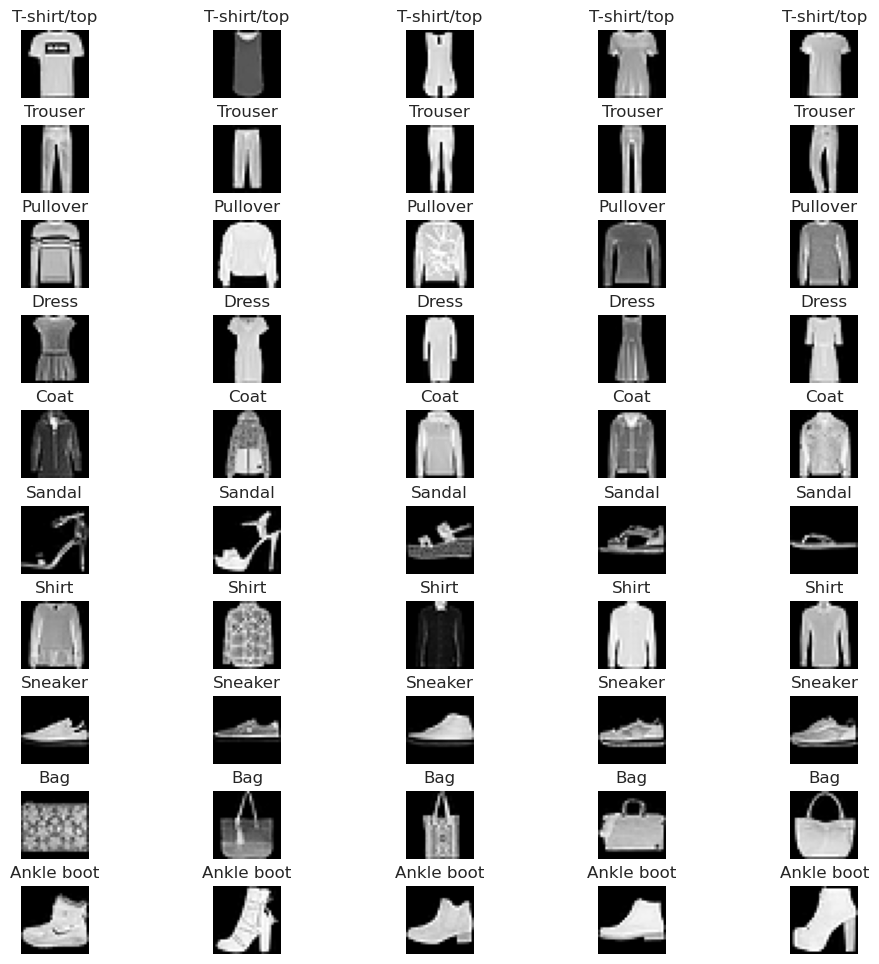

Minimum pixel value: 0
Maximum pixel value: 255


In [147]:
# YOUR CODE HERE

# Display first five images in X_train for each class in y_train
# Create a figure to plot the 10x5 grid
fig, axes = plt.subplots(10, 5, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4)

# Track how many images of each class we've plotted
count = {i: 0 for i in range(10)}

# Loop over X_train and Y_train to find the first 5 images per class
for i in range(len(X_train)):
    label = Y_train[i]
    if count[label] < 5:
        ax = axes[label, count[label]]
        ax.imshow(X_train[i], cmap='gray')
        ax.axis('off')
        ax.set_title(label_names[label])
        count[label] += 1
    
    # Stop once we have 5 images for each class
    if all(count == 5 for count in count.values()):
        break

# Display the grid
plt.show()

# Determine the minimum and maximum pixel values in X_train
min_pixel_value = np.min(X_train)
max_pixel_value = np.max(X_train)

# Print the min and max pixel values
print(f"Minimum pixel value: {min_pixel_value}")
print(f"Maximum pixel value: {max_pixel_value}")

---
### Step 3: Data preprocessing

This step is essential for preparing this image data in a format that is suitable for ML algorithms. 

### <span style="color:chocolate">Exercise 3:</span> Feature preprocessing (5 points)

In the previous lab, the input data had just a few features. Here, we treat **every pixel value as a separate feature**, so each input example has 28x28 (784) features!

In this exercise, you'll perform the following tasks:

1. Normalize the pixel values in both X_train and X_test data so they range between 0 and 1;
2. For each image in X_train and X_test, flatten the 2-D 28x28 pixel array to a 1-D array of size 784. Hint: use the <span style="color:chocolate">reshape()</span> method available in NumPy. Note that by doing so you will overwrite the original arrays;
3. Pint the shape of X_train and X_test arrays.

In [148]:
# YOUR CODE HERE
# 1. Normalize data
X_train = X_train/max_pixel_value
X_test = X_test/max_pixel_value

# 2. Flatten
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]  * X_test.shape[2] )

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (60000, 784)
X_test shape: (10000, 784)


### <span style="color:chocolate">Exercise 4:</span> Label preprocessing (5 points)

This assignment involves binary classification. Specifically, the objective is to predict whether an image belongs to the sneaker class (class 7) or not.

Therefore, write code so that for each example in (Y_train, Y_test), the outcome variable is represented as follows: 
* $y=1$, for sneaker class (positive examples), and
* $y=0$, for non-sneaker class (negative examples).

Note: To avoid "ValueError: assignment destination is read-only", first create a copy of the (Y_train, Y_test) data and call the resulting arrays (Y_train, Y_test). Then overwrite the (Y_train, Y_test) arrays to create binary outcomes.

In [149]:
# Make copies of the original dataset for binary classification task.
Y_train = np.copy(Y_train)
Y_test = np.copy(Y_test)

# YOUR CODE HERE
# Turn data into binary output for sneaker class
Y_train = np.where(Y_train == 7, 1, 0)
Y_test = np.where(Y_test == 7, 1, 0)


### <span style="color:chocolate">Exercise 5:</span> Data splits (10 points)

Using the <span style="color:chocolate">train_test_split()</span> method available in scikit-learn:
1. Retain 20% from the training data for validation purposes. Set random state to 1234. All the other arguments of the method are set to default values. Name the resulting dataframes as follows: X_train_mini, X_val, Y_train_mini, Y_val.
2. Print the shape of each array.

In [150]:
# YOUR CODE HERE
# 1. Test train split
X_train_mini, X_val, Y_train_mini, Y_val = train_test_split(X_train, Y_train, test_size= 0.2 , random_state= 1234)

# 2. Printing the shape of each array
print(f"X_train_mini shape: {X_train_mini.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"Y_train_mini shape: {Y_train_mini.shape}")
print(f"Y_val shape: {Y_val.shape}")

X_train_mini shape: (48000, 784)
X_val shape: (12000, 784)
Y_train_mini shape: (48000,)
Y_val shape: (12000,)


### <span style="color:chocolate">Exercise 6:</span> Data shuffling (10 points)

Since you'll be using Batch Gradient Descent (BGD) for training, it is important that **each batch is a random sample of the data** so that the gradient computed is representative. 

1. Use [integer array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#integer-array-indexing) to re-order (X_train_mini, Y_train_mini) using a list of shuffled indices. In doing so, you will overwrite the arrays.

In [151]:
np.random.seed(0)
# YOUR CODE HERE

# Create list of indices corresponding to the rows in X_train_mini, Y_train_mini dataset
indices = np.arange(X_train_mini.shape[0])
# Shuffle indices
shuffled_indices = np.random.permutation(indices_X)

# Change the ordering of the X_train_mini, Y_train_mini datasets based on shuffles_indices
X_train_mini = X_train_mini[shuffled_indices]
Y_train_mini = Y_train_mini[shuffled_indices]

---
### Step 4: Exploratory Data Analysis (EDA) - cont'd

Before delving into model training, let's further explore the raw feature values by comparing sneaker and non-sneaker training images.

### <span style="color:chocolate">Exercise 7:</span> Pixel distributions (10 points)

1. Identify all sneaker images in X_train_mini and calculate the mean pixel value for each sneaker image. Visualize these pixel values using a histogram. Print the mean pixel value across all sneaker images.
2. Identify all non-sneaker images in X_train_mini and calculate the mean pixel value for each non-sneaker image. Visualize these pixel values using a histogram. Print the mean pixel value across all non-sneaker images.
3. Based on the histogram results, assess whether there is any evidence suggesting that pixel values can be utilized to distinguish between sneaker and non-sneaker images. Justify your response.

Notes: Make sure to provide a descriptive title and axis labels for each histogran. Make sure you utilize Y_train_mini to locate the sneaker and non-sneaker class.

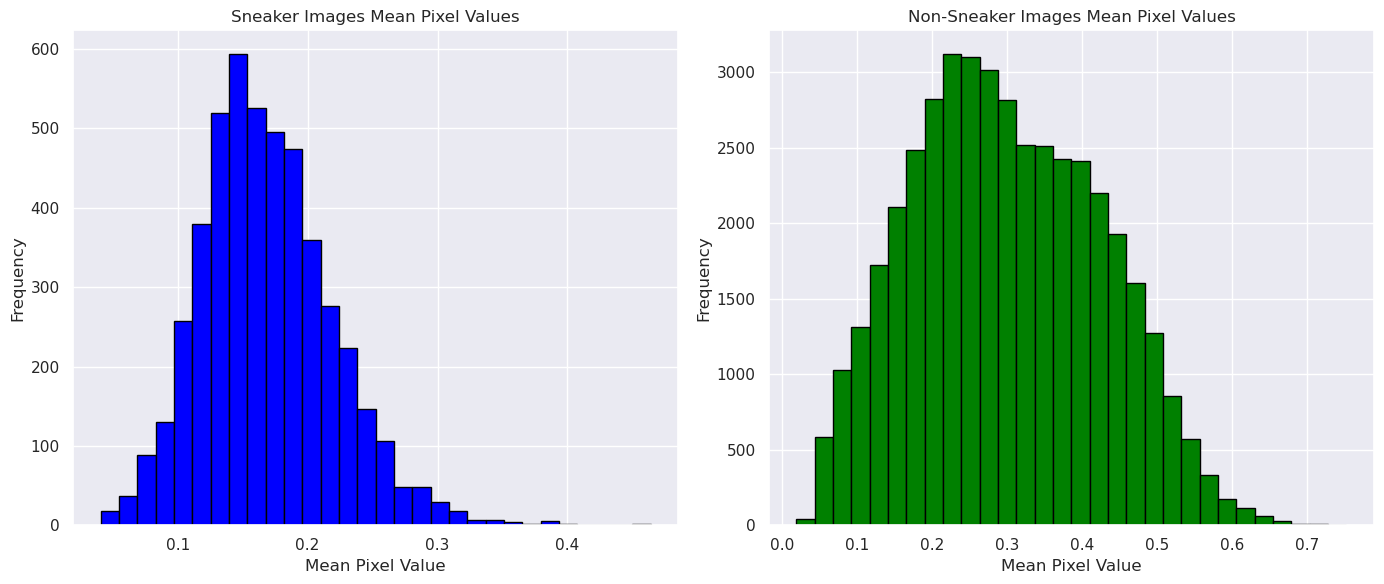

Sneaker mean pixel value across all images: 0.1682747275993731
Non-Sneaker mean pixel value across all images: 0.2990019268123916


In [152]:
# YOUR CODE HERE

# 1. Identify sneakers and calculate the mean pixel value
# Identify sneakers (class 7)
sneakers_id = np.where(Y_train_mini == 1)
sneakers = X_train_mini[sneakers_id]

# Get sneaker mean
sneaker_mean = sneakers.mean(axis = 1)

# *********************************************************
# 2. Identify non-sneakers and calculate the mean pixel value
# Identify non-sneakers
non_sneakers_id = np.where(Y_train_mini == 0)
non_sneakers = X_train_mini[non_sneakers_id]

# Get non-sneaker mean
non_sneaker_mean = non_sneakers.mean(axis = 1)

# Create a figure and plot both histograms side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Sneakers histogram of mean pixel values
ax[0].hist(sneaker_mean, bins=30, color='blue', edgecolor='black')
ax[0].set_title('Sneaker Images Mean Pixel Values')
ax[0].set_xlabel('Mean Pixel Value')
ax[0].set_ylabel('Frequency')

# Non-Sneakers histogram of mean pixel values
ax[1].hist(non_sneaker_mean, bins=30, color='green', edgecolor='black')
ax[1].set_title('Non-Sneaker Images Mean Pixel Values')
ax[1].set_xlabel('Mean Pixel Value')
ax[1].set_ylabel('Frequency')

# Display the side-by-side plots
plt.tight_layout()
plt.show()

# Print the mean pixel value across all sneaker and non-sneaker images
mean_sneaker_pixel_value = np.mean(sneaker_mean)
mean_non_sneaker_pixel_value = np.mean(non_sneaker_mean)

print(f"Sneaker mean pixel value across all images: {mean_sneaker_pixel_value}")
print(f"Non-Sneaker mean pixel value across all images: {mean_non_sneaker_pixel_value}")

With no significant difference between the mean pixel values for both sneakers and non-sneaker images, there is no practical method of discerning between the sneakers and non-sneaker images. This is to be expected as color is not a good indicator of clothing especially when the images in the dataset are all black and white.

There is NO evidence suggesting that pixel values can be utilized to distinguish between sneaker and non-sneaker images.

---
### Step 4: Modeling

### <span style="color:chocolate">Exercise 8:</span> Baseline model (10 points)

When dealing with classification problems, a simple baseline is to select the *majority* class (the most common label in the training set) and use it as the prediction for all inputs.

With this information in mind:

1. What is the number of sneaker images in Y_train_mini?
2. What is the number of non-sneaker images in Y_train_mini?
3. What is the majority class in Y_train_mini?
4. What is the accuracy of a majority class classifier for Y_train_mini?
5. Implement a function that computes the Log Loss (binary cross-entropy) metric and use it to evaluate this baseline on both the mini train (Y_train_mini) and validation (Y_val) data. Use 0.1 as the predicted probability for your baseline (reflecting what we know about the original distribution of classes in the mini training data). Hint: for additional help, see the file ``04 Logistic Regression with Tensorflow_helpers.ipynb``.

In [153]:
# YOUR CODE HERE
# 1. Number of sneaker images in Y_train_mini
num_sneakers = np.count_nonzero(Y_train_mini)
print(f"Number of sneaker images in Y_train_mini: {num_sneakers}")

# 2. Number of non-sneaker images in Y_train_mini
num_non_sneakers = np.count_nonzero(Y_train_mini == 0)
print(f"Number of non-sneaker images in Y_train_mini: {num_non_sneakers}")

# 3. Majority Class
majority_class = 'Sneakers' if num_sneakers > num_non_sneakers else 'Non-sneakers'
print(f"\nMajority class in Y_train_mini: {majority_class}")

# 4. Majority Class accuracy
majority_class_accuracy = max(num_sneakers, num_non_sneakers) / len(Y_train_mini)
print(f"Majority class classifier accuracy: {majority_class_accuracy}")

# 5a. Log-loss Function
def log_loss(preds, true):
    # preds : predictons
    # true : true values/observed values
    return (-true * np.log(preds) - (1 - true) * np.log(1 - preds)).mean()

# 5b. Implement log_loss for baseline
train_log_loss = log_loss(0.1, Y_train_mini)
print(f"\nLog Loss on Y_train_mini: {train_log_loss:.4f}")
val_log_loss = log_loss(0.1, Y_val)
print(f"Log Loss on Y_val: {val_log_loss:.4f}")

Number of sneaker images in Y_train_mini: 4800
Number of non-sneaker images in Y_train_mini: 43200

Majority class in Y_train_mini: Non-sneakers
Majority class classifier accuracy: 0.9

Log Loss on Y_train_mini: 0.3251
Log Loss on Y_val: 0.3251


### <span style="color:chocolate">Exercise 9:</span> Improvement over Baseline with TensorFlow (10 points)

Let's use TensorFlow to train a binary logistic regression model much like you did in the previous assignment. The goal here is to build a ML model to improve over the baseline classifier.

1. Fill in the <span style="color:green">NotImplemented</span> parts of the build_model() function below by following the instructions provided as comments. Hint: the activation function, the loss, and the evaluation metric are different compared to the linear regression model;
2. Build and compile a model using the build_model() function and the (X_train_mini, Y_train_mini) data. Set learning_rate = 0.0001. Call the resulting object *model_tf*.
3. Train *model_tf* using the (X_train_mini, Y_train_mini) data. Set num_epochs = 5 and batch_size=32. Pass the (X_val, Y_val) data for validation. Hint: see the documentation behind the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method.
3. Generate a plot (for the mini training and validation data) with the loss values on the y-axis and the epoch number on the x-axis for visualization. Make sure to include axes name and title. Hint: check what the [tf.keras.Model.fit()](https://bcourses.berkeley.edu/courses/1534588/files/88733489?module_item_id=17073646) method returns.

In [154]:
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        # output dim
      input_shape=(num_features, ),  # input dim
      use_bias=True,                 # use a bias (intercept) param
      activation='sigmoid',          # apply a sigmoid to the output
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    
  return model

/home/jdhesi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/tmp/ipykernel_5630/1437085521.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"


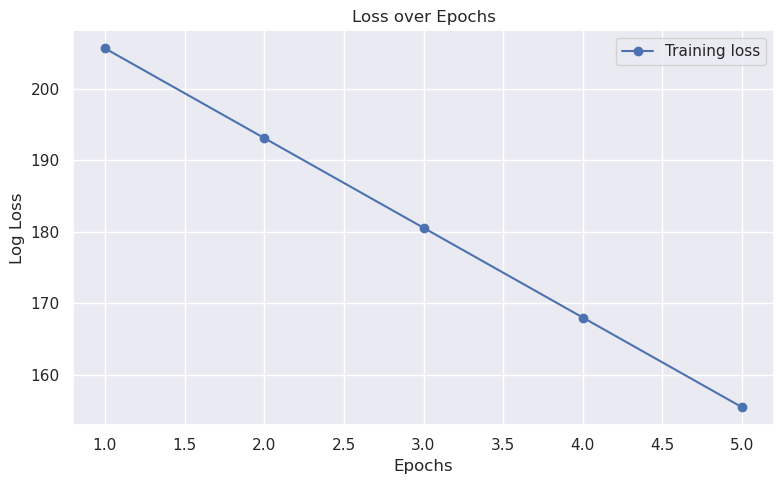

In [155]:
tf.random.set_seed(0)
# 2. Build and compile model
LR = 0.0001
model_tf = build_model(X_train_mini.shape[1], learning_rate=LR)

# 3. Fit the model
# Do a single gradient update.
model_history = model_tf.fit(
  x=X_train_mini,
    y=Y_train_mini,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, Y_val),  # Validation data added
    verbose=0
)

# 4 Plot loss values
history_dict = model_history.history
history_dict.keys()

# Get the model Loss
loss = history_dict['loss']

# Create a range of epoch numbers to match the length of the loss list
epochs = range(1, len(loss) + 1)  # Create a list of epochs starting from 1 to the number of epochs

# Plot the losses vs epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.tight_layout()
plt.legend()
plt.show()

---
### Step 5: Hyperparameter tuning

Hyperparameter tuning is a crucial step in optimizing ML models. It involves systematically adjusting hyperparameters such as learning rate, number of epochs, and optimizer to find the model configuration that leads to the best generalization performance.

This tuning process is typically conducted by monitoring the model's performance on the validation vs. training set. It's important to note that using the test set for hyperparameter tuning can compromise the integrity of the evaluation process by violating the assumption of "blindness" of the test data.

### <span style="color:chocolate">Exercise 10:</span> Hyperparameter tuning (10 points)

1. Fine-tune the **learning rate** and **number of epochs** hyperparameters of *model_tf* to determine the setup that yields the most optimal generalization performance. Feel free to explore various values for these hyperparameters. Hint: you can manually test different hyperparameter values or you can use the [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner). If you decide to work with the Keras Tuner, define a new model building function named <span style="color:chocolate">build_model_tuner()</span>.

After identifying your preferred model configuration, print the following information:

2. The first five learned parameters of the model (this should include the bias term);
3. The loss at the final epoch on both the mini training and validation datasets;
4. The percentage difference between the losses observed on the mini training and validation datasets.
5. Compare the training/validation loss of the TensorFlow model (model_tf) with the baseline model's loss. Does the TensorFlow model demonstrate an improvement over the baseline model?


Please note that we will consider 'optimal model configuration' any last-epoch training and validation loss that is below 0.08.

/tmp/ipykernel_5630/4116654003.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs_tuned, loss_tuned, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"


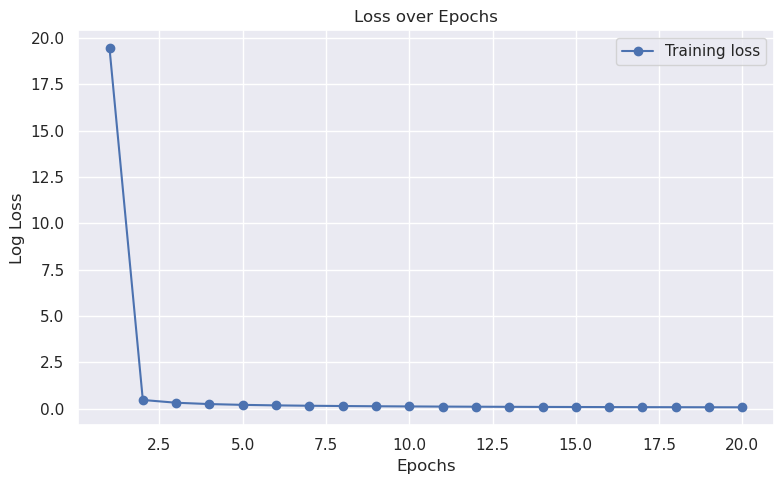

***************
Learned Parameters of the tuned model:
Weights (Kernel): 
[[0.99982005]
 [0.9994479 ]
 [0.9963999 ]
 [0.98872155]
 [0.9710966 ]]
Bias (Intercept): 
[-2.267536]

Last Epoch Values (rounded to 4 decimals): 
Epoch: 20; Loss = 0.0798; val_loss = 0.0759 

Difference between last validation and training loss (rounded to 4 decimals): -4.8872%

 Baseline Log Loss on Y_train_mini: 0.3251
Baseline Log Loss on Y_val: 0.3251

 Tuned Log Loss on Y_train_mini: 0.0798
Tuned Log Loss on Y_val: 0.0759


In [172]:
# 1. Hypertune the model
tf.random.set_seed(0)
LR = 0.0099
model_tf_tuned = build_model(X_train_mini.shape[1], learning_rate=LR)

# Do a single gradient update.
model_history_tuned = model_tf_tuned.fit(
  x=X_train_mini,
  y=Y_train_mini,
  epochs=20,
  batch_size=32,
  validation_data=(X_val, Y_val),  # Validation data added
  verbose=0)

# 4 Plot loss values
history_dict_tuned = model_history_tuned.history
history_dict_tuned.keys()

# Get the model Loss
loss_tuned = history_dict_tuned['loss']

# Create a range of epoch numbers to match the length of the loss list
epochs_tuned = range(1, len(loss_tuned) + 1)  # Create a list of epochs starting from 1 to the number of epochs

# Plot the losses vs epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs_tuned, loss_tuned, 'bo', linestyle='-', color='b', label='Training loss') # "bo" is for "blue dot"
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.tight_layout()
plt.legend()
plt.show()

# 2. Print the first 5 hypertuning parameters
weights, bias = model_tf_tuned.layers[0].get_weights()
print("***************")
print("Learned Parameters of the tuned model:")
print(f"Weights (Kernel): \n{weights[0:5]}")
print(f"Bias (Intercept): \n{bias}")

# 3. Print loss and val_loss for last epoch
train_loss_final = round(loss_tuned[-1],4)
val_loss_final = round(history_dict_tuned['val_loss'][-1],4)
print(f"\nLast Epoch Values (rounded to 4 decimals):",
      f"\nEpoch: {max(epochs_tuned)}; Loss = {train_loss_final}; val_loss = {val_loss_final} ")

# 4. Calculate and print the percent difference between the last-epoch training and validation loss
loss_pct_difference = round(100*(val_loss_final - train_loss_final)/train_loss_final, 4)
print(f"\nDifference between last validation and training loss (rounded to 4 decimals): {loss_pct_difference}%")

# 5. Compare tuned loss to baseline loss
print(f"\n Baseline Log Loss on Y_train_mini: {train_log_loss:.4f}")
print(f"Baseline Log Loss on Y_val: {val_log_loss:.4f}")
print(f"\n Tuned Log Loss on Y_train_mini: {train_loss_final:.4f}")
print(f"Tuned Log Loss on Y_val: {val_loss_final:.4f}")

With the tuned model yielding training and validation loss values of less than 0.08, we see considerable improvement compared to the baseline values.

---
### Step 6: Evaluation and Generalization


Now that you've determined the optimal set of hyperparameters, it's time to evaluate your optimized model on the test data to gauge its performance in real-world scenarios, commonly known as inference.

### <span style="color:chocolate">Exercise 11:</span> Computing accuracy (10 points)

1. Calculate aggregate accuracy on both mini train and test datasets using a probability threshold of 0.5. Hint: You can utilize the <span style="color:chocolate">model.evaluate()</span> method provided by tf.keras. Note: Aggregate accuracy measures the overall correctness of the model across all classes in the dataset;

2. Does the model demonstrate strong aggregate generalization capabilities? Provide an explanation based on your accuracy observations.

In [177]:
# 1a. Evaluate accuracy on the training dataset
train_loss, train_accuracy = model_tf_tuned.evaluate(X_train_mini, Y_train_mini, verbose=0)
print(f"Training Accuracy: {100*train_accuracy:.4f}%")

# 1b. Evaluate accuracy on the validation dataset
val_loss, val_accuracy = model_tf_tuned.evaluate(X_val, Y_val, verbose=0)
print(f"Validation Accuracy: {100*val_accuracy:.4f}%")

Training Accuracy: 97.3750%
Validation Accuracy: 97.0250%


With greater than 97% accuracy across training and validation data, the data demonstrates strong aggregate generalization capabilities. However, the large number of epochs used raises some concern regarding overfitting.

### <span style="color:chocolate">Exercise 12:</span> Fairness evaluation (10 points)

1. Generate and visualize the confusion matrix on the test dataset using a probability threshold of 0.5. Additionally, print the True Positives (TP), False Negatives (FN), False Positives (FP), and True Negatives (TN). Hint: you can utilize the <span style="color:chocolate">model.predict()</span> method available in tf.keras, and then the <span style="color:chocolate">confusion_matrix()</span>, <span style="color:chocolate">ConfusionMatrixDisplay()</span> methods available in sklearn.metrics;

2. Compute subgroup accuracy, separately for the sneaker and non-sneaker classes, on the test dataset using a probability threshold of 0.5. Reflect on any observed accuracy differences (potential lack of fairness) between the two classes.

3. Does the model demonstrate strong subgroup generalization capabilities? Provide an explanation based on your accuracy observations.

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


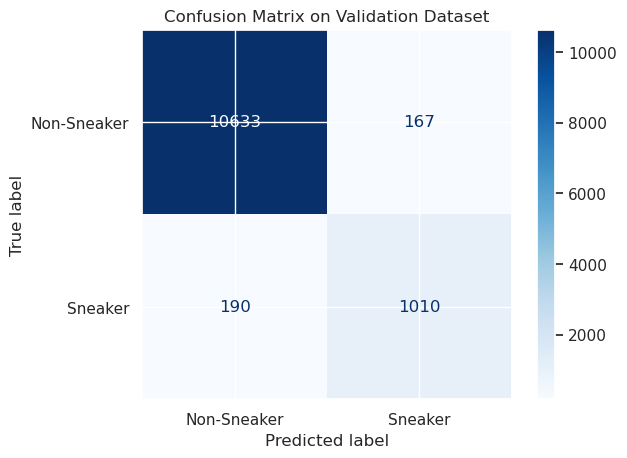

True Positives (TP): 1010
False Negatives (FN): 190
False Positives (FP): 167
True Negatives (TN): 10633


In [180]:
# 1. Generate confusion matrix and print TP, FN, FP, TN
# test dataset predictions
predictions = model_tf_tuned.predict(X_val)

# Convert probabilities to binary predictions using 0.5 threshold
binary_predictions = (predictions >= 0.5).astype(int)
# Confusion matrix
cm = confusion_matrix(Y_val, binary_predictions)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Sneaker", "Sneaker"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Dataset")
plt.show()

# Extracting TP, FN, FP, TN from the confusion matrix
TN, FP, FN, TP = cm.ravel()

print(f"True Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")

In [182]:
# 2. Compute subgroup accuracy, separately for the sneaker and non-sneaker classes
# Calculate accuracy for the sneaker class
sneaker_indices = (Y_val == 1)
sneaker_accuracy = np.mean(binary_predictions[sneaker_indices] == Y_val[sneaker_indices])

# Calculate accuracy for the non-sneaker class
non_sneaker_indices = (Y_val == 0)
non_sneaker_accuracy = np.mean(binary_predictions[non_sneaker_indices] == Y_val[non_sneaker_indices])

print(f"Sneaker class accuracy: {100*sneaker_accuracy:.4f}%")
print(f"Non-sneaker class accuracy: {100*non_sneaker_accuracy:.4f}%")

Sneaker class accuracy: 84.1667%
Non-sneaker class accuracy: 98.4537%


3. With an accuracy difference of 14% between the sneakers and non-sneakers subgroups, the model CANNOT be said to generalize well for different subgroups. For the model to generalize well there must be a roughly equal accuracy across all subgroups. The large gap in accuracy suggests the model to struggle with the sneaker subgroup.

----
#### <span style="color:chocolate">Additional practice question</span> (not graded)

Is it possible to enhance the prediction accuracy for the sneaker class by performing the following steps?

1. Implement data balancing techniques, such as oversampling or undersampling, to equalize the representation of both classes.
2. After balancing the data, retrain the model on the balanced dataset.
3. Evaluate the model's performance, particularly focusing on the accuracy achieved for the sneaker class.